In [1]:
import pandas as pd
import numpy as np
import collections
import pprint
import random

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,6)

In [2]:
df = pd.read_csv('weatherAUS.csv.zip', compression='zip')
df = df.drop(['RainToday', 'Date'], axis=1)

In [3]:
df.sample(5)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
107173,Woomera,10.9,27.5,0.0,7.8,7.1,NNW,67.0,ENE,ESE,...,11.0,47.0,20.0,1017.1,1011.8,3.0,3.0,17.4,25.7,Yes
30093,Richmond,13.2,22.2,9.4,1.6,NaN,W,48.0,SW,SSW,...,15.0,77.0,93.0,1028.7,1026.7,8.0,7.0,18.2,17.0,Yes
13382,Moree,11.0,24.5,0.0,16.0,NaN,SW,56.0,W,W,...,28.0,26.0,17.0,1013.9,1012.3,3.0,3.0,19.1,23.1,No
60289,Bendigo,13.6,23.0,0.2,NaN,NaN,SW,35.0,SSW,SSW,...,20.0,74.0,48.0,1008.8,1007.7,8.0,7.0,14.9,20.8,No
72938,Mildura,8.9,23.6,0.0,7.2,11.1,S,37.0,SSW,S,...,20.0,76.0,31.0,1017.9,1016.3,1.0,3.0,12.4,21.8,No


In [4]:
df.RainTomorrow.value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [ ]:
# Задание 1: провести EDA (Explanatory Data Analysis)

# Желательно построить графики по некоторым, на ваш взгляд, ключевым признакам и целевой переменной,
# чтобы оценить данные, с которыми мы работаем. Это задание полностью творческое и будет оценено субъективно
# с точки зрения степени раскрытия инсайтов и "красивости" графиков и статистических расчетов


# Задание 2:

# Данные, которые мы видим, представлены в табличном формате и имеют несколько проблем, требующих решения:

# 1) Есть пропущенные значения (вероятно, некоторые колонки или строчки следовательно необходимо убрать)
# 2) Некоторые признаки представлены не в виде числовых данных (нужно закодировать с помощью Label Encoder)
# 3) Дизбаланс данных (не каждый метод оценки подойдет)
# 4) Данные имеют разный разброс. Вероятно, требуется скейлинг

# EDA + data processing

### *Общий обзор данных*

In [5]:
# Посмотрим на общую инфо о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  object 
 1   MinTemp        143975 non-null  float64
 2   MaxTemp        144199 non-null  float64
 3   Rainfall       142199 non-null  float64
 4   Evaporation    82670 non-null   float64
 5   Sunshine       75625 non-null   float64
 6   WindGustDir    135134 non-null  object 
 7   WindGustSpeed  135197 non-null  float64
 8   WindDir9am     134894 non-null  object 
 9   WindDir3pm     141232 non-null  object 
 10  WindSpeed9am   143693 non-null  float64
 11  WindSpeed3pm   142398 non-null  float64
 12  Humidity9am    142806 non-null  float64
 13  Humidity3pm    140953 non-null  float64
 14  Pressure9am    130395 non-null  float64
 15  Pressure3pm    130432 non-null  float64
 16  Cloud9am       89572 non-null   float64
 17  Cloud3pm       86102 non-null

In [6]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


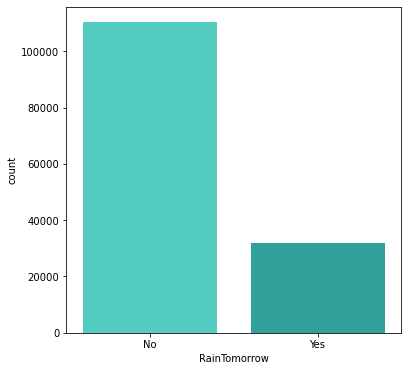

In [7]:
# Посмотрим на распределение нашей целевой переменной

sns.countplot(df['RainTomorrow'], palette=['turquoise',"lightseagreen"])

Распределение неравномерное. Вероятность дождя очень мала.

Имеем 5 категориальных переменных и 15 числовых. Проверим на наличие Nan.

In [8]:
columns = list(df.columns)
print(columns)

['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainTomorrow']


In [9]:
# Функция для поиска количества пустых значений

def are_there_nan(cols, data):
    for col in cols:
        print(col, ":", data[col].isna().sum())

In [10]:
are_there_nan(columns, df)

Location : 0
MinTemp : 1485
MaxTemp : 1261
Rainfall : 3261
Evaporation : 62790
Sunshine : 69835
WindGustDir : 10326
WindGustSpeed : 10263
WindDir9am : 10566
WindDir3pm : 4228
WindSpeed9am : 1767
WindSpeed3pm : 3062
Humidity9am : 2654
Humidity3pm : 4507
Pressure9am : 15065
Pressure3pm : 15028
Cloud9am : 55888
Cloud3pm : 59358
Temp9am : 1767
Temp3pm : 3609
RainTomorrow : 3267


In [11]:
# сколько процентов данных пропущено
def procentage(data):
    for col in data.columns:
        missing = np.mean(data[col].isnull())
        print ('{} - {}%'.format(col, round(missing*100)))

In [12]:
procentage(df)

Location - 0%
MinTemp - 1%
MaxTemp - 1%
Rainfall - 2%
Evaporation - 43%
Sunshine - 48%
WindGustDir - 7%
WindGustSpeed - 7%
WindDir9am - 7%
WindDir3pm - 3%
WindSpeed9am - 1%
WindSpeed3pm - 2%
Humidity9am - 2%
Humidity3pm - 3%
Pressure9am - 10%
Pressure3pm - 10%
Cloud9am - 38%
Cloud3pm - 41%
Temp9am - 1%
Temp3pm - 2%
RainTomorrow - 2%


Строки, где процентность ошибок не превышает 5%, в принципе можно удалить, т.к. это не сильно повлияет на наши данные. Однако, есть столбцы, где Nan занимает около половины строк. Посмотрим на них отдельно позже.

### *Работа с пропусками*

In [13]:
# Удалим строки с nan в столбцах MinTemp, MaxTemp, Rainfall, WindDir3pm, WindSpeed9am, WindSpeed3pm, Temp9am, Temp3pm, RainTomorrow

data = df.dropna(subset = ["MinTemp", "MaxTemp", "Rainfall", "WindDir3pm", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", 
                           "Temp9am", "Humidity3pm","Temp3pm", "RainTomorrow"])

In [14]:
cols = ["MinTemp", "MaxTemp", "Rainfall", "WindDir3pm", "WindSpeed9am", "WindSpeed3pm", "Temp9am", "Temp3pm", "RainTomorrow"]

In [15]:
for col in cols:
    pprint.pprint(data[col].isna().value_counts())

False    134590
Name: MinTemp, dtype: int64
False    134590
Name: MaxTemp, dtype: int64
False    134590
Name: Rainfall, dtype: int64
False    134590
Name: WindDir3pm, dtype: int64
False    134590
Name: WindSpeed9am, dtype: int64
False    134590
Name: WindSpeed3pm, dtype: int64
False    134590
Name: Temp9am, dtype: int64
False    134590
Name: Temp3pm, dtype: int64
False    134590
Name: RainTomorrow, dtype: int64


Посмотрим отдельно на **категориальные** переменные.


In [16]:
data["Location"].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [17]:
data["WindGustDir"].value_counts(ascending=False)

W      9499
SE     9042
N      8730
SSE    8720
S      8694
E      8670
WSW    8625
SW     8556
SSW    8382
WNW    7776
NW     7743
ENE    7685
ESE    7001
NE     6855
NNW    6360
NNE    6238
Name: WindGustDir, dtype: int64

In [18]:
data["WindGustDir"].isna().value_counts()

False    128576
True       6014
Name: WindGustDir, dtype: int64

Так как пропусков в данном столбце довольно много, а значение, которым можно было бы заполнить пропуски, недостаточно велико, заполним Nan новым значением **UK - unknown**

In [19]:
data['WindGustDir'] = data['WindGustDir'].fillna("UK")

<ipython-input-19-05b90a63f695>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['WindGustDir'] = data['WindGustDir'].fillna("UK")


In [20]:
# Смотрим на след. столбик
data["WindDir9am"].isna().value_counts()

False    127033
True       7557
Name: WindDir9am, dtype: int64

Думаю, здесь стоит поступить так же, как и с прошлой колонкой, т.к., если мы заменим все на N, то таких значений станет гораздо больше, что нарушит общее распределение данных

In [21]:
data['WindDir9am'] = data['WindDir9am'].fillna("UK")

<ipython-input-21-fc3e808dac09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['WindDir9am'] = data['WindDir9am'].fillna("UK")


### fill_Na of  Numerical values

Теперь посмотрим на числовые признаки, в которых есть пропущенные значения.

In [22]:
data["Evaporation"].isna().value_counts()

False    78489
True     56101
Name: Evaporation, dtype: int64

Пропущено больше половины значений. Есть несколько вариантов: удалить столбец совсем (но тогда потенциально нужные данные потеряем), либо воспользоваться одним из методов заполнения.

In [23]:
# Запоминаем категориальные признаки
data_categorical = data[["Location","WindGustDir","WindDir9am","WindDir3pm","RainTomorrow"]]

In [24]:
# Запоминаем числовые переменные
data_num = data[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']]

### Knn_inputer

In [27]:
# Попробуем заполнить пропуски с помошью KnnImputer
imputer = KNNImputer(n_neighbors=3)

In [28]:
df_filled = imputer.fit_transform(data_num)

In [29]:
df_filled

array([[13.4       , 22.9       ,  0.6       , ...,  4.        ,
        16.9       , 21.8       ],
       [ 7.4       , 25.1       ,  0.        , ...,  1.66666667,
        17.2       , 24.3       ],
       [12.9       , 25.7       ,  0.        , ...,  2.        ,
        21.        , 23.2       ],
       ...,
       [ 3.6       , 25.3       ,  0.        , ...,  2.66666667,
        10.9       , 24.5       ],
       [ 5.4       , 26.9       ,  0.        , ...,  2.33333333,
        12.5       , 26.1       ],
       [ 7.8       , 27.        ,  0.        , ...,  2.        ,
        15.1       , 26.        ]])

In [30]:
data_numerical = pd.DataFrame(df_filled, columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'])

In [33]:
data_numerical

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,13.4,22.9,0.6,9.600000,9.833333,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.000000,16.9,21.8
1,7.4,25.1,0.0,8.200000,10.966667,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,1.333333,1.666667,17.2,24.3
2,12.9,25.7,0.0,7.133333,11.133333,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,1.333333,2.000000,21.0,23.2
3,9.2,28.0,0.0,7.333333,10.566667,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,2.000000,2.333333,18.1,26.5
4,17.5,32.3,1.0,4.400000,8.700000,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134585,3.5,21.8,0.0,5.133333,11.600000,31.0,15.0,13.0,59.0,27.0,1024.7,1021.2,0.000000,0.000000,9.4,20.9
134586,2.8,23.4,0.0,4.400000,9.433333,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,2.333333,2.000000,10.1,22.4
134587,3.6,25.3,0.0,3.666667,10.200000,22.0,13.0,9.0,56.0,21.0,1023.5,1019.1,1.000000,2.666667,10.9,24.5
134588,5.4,26.9,0.0,5.000000,10.800000,37.0,9.0,9.0,53.0,24.0,1021.0,1016.8,2.000000,2.333333,12.5,26.1


### Посмотрим на распределение признаков и проверим данные на наличие выбросов

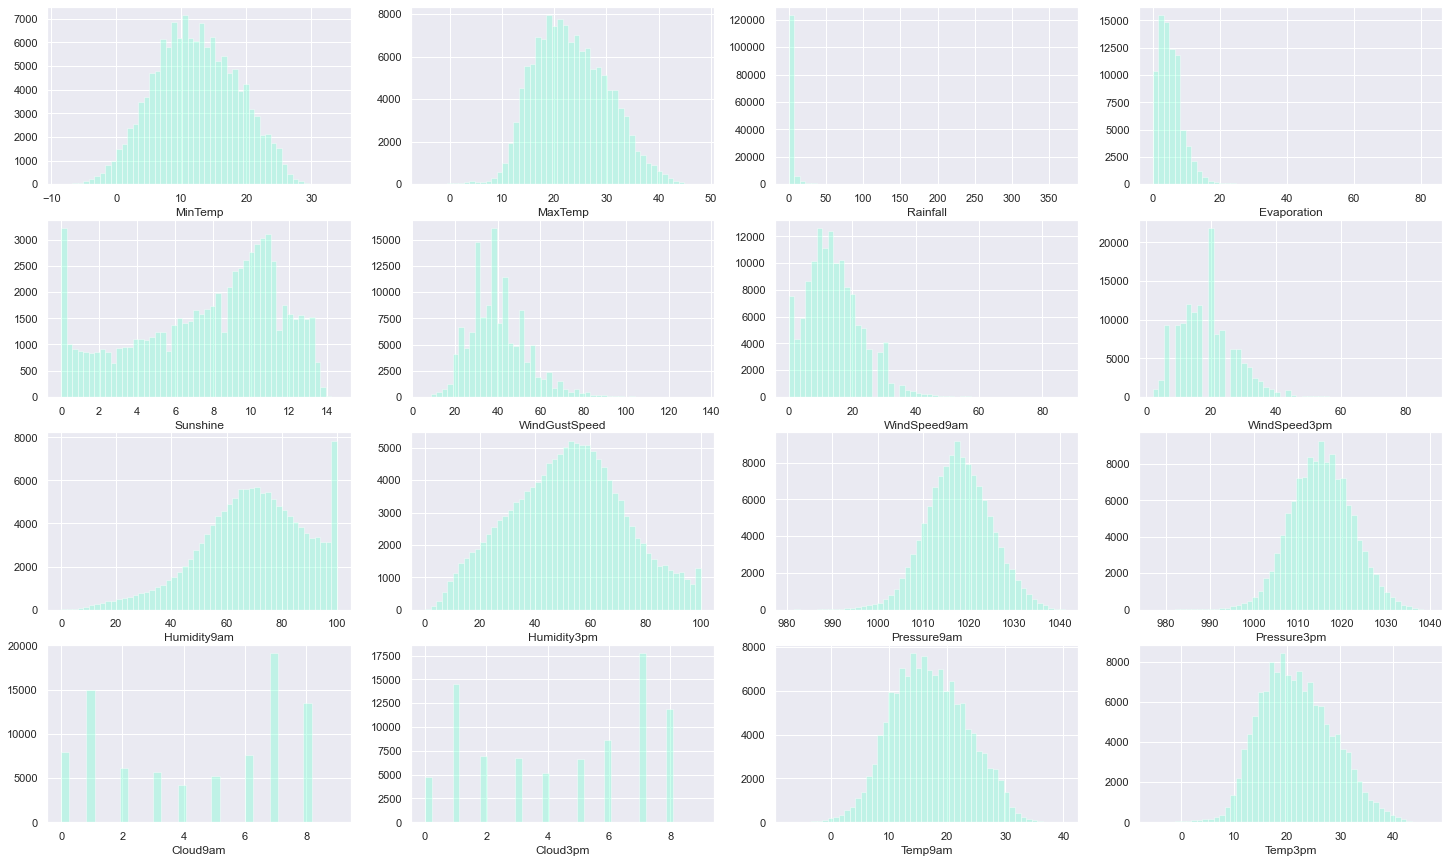

In [44]:
fig, axes = plt.subplots(4, 4, figsize=(25,15))

for i,col in enumerate(data_numerical):
    sns.set()
    sns.distplot(data[col], kde=False, ax=axes.flat[i], color="aquamarine")

#### Судя по графикам, в данных имеются выбросы.

In [35]:
data_numerical.corr()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
MinTemp,1.000000,0.732378,0.105069,0.509426,0.093968,0.174686,0.180604,0.176063,-0.237742,0.007891,-0.438991,-0.450675,0.076937,0.023748,0.900858,0.707509
MaxTemp,0.732378,1.000000,-0.074822,0.639610,0.507011,0.066534,0.014832,0.045058,-0.510091,-0.509097,-0.312565,-0.407813,-0.312693,-0.310961,0.885901,0.984520
Rainfall,0.105069,-0.074822,1.000000,-0.054924,-0.253572,0.131777,0.088237,0.061138,0.224310,0.255368,-0.170152,-0.128266,0.215870,0.191684,0.010498,-0.078625
Evaporation,0.509426,0.639610,-0.054924,1.000000,0.388803,0.227342,0.212194,0.156946,-0.550286,-0.426749,-0.290536,-0.319481,-0.230898,-0.226038,0.602968,0.622601
Sunshine,0.093968,0.507011,-0.253572,0.388803,1.000000,-0.025154,-0.006382,0.050855,-0.534938,-0.693420,0.038466,-0.027183,-0.676638,-0.698412,0.319283,0.529897
WindGustSpeed,0.174686,0.066534,0.131777,0.227342,-0.025154,1.000000,0.605317,0.690951,-0.213901,-0.025871,-0.461868,-0.415276,0.069010,0.114834,0.145775,0.027489
WindSpeed9am,0.180604,0.014832,0.088237,0.212194,-0.006382,0.605317,1.000000,0.514333,-0.267352,-0.026109,-0.233152,-0.179204,0.032191,0.070286,0.129843,-0.000734
WindSpeed3pm,0.176063,0.045058,0.061138,0.156946,0.050855,0.690951,0.514333,1.000000,-0.136039,0.029778,-0.304534,-0.264175,0.061487,0.040877,0.161867,0.018691
Humidity9am,-0.237742,-0.510091,0.224310,-0.550286,-0.534938,-0.213901,-0.267352,-0.136039,1.000000,0.668347,0.135447,0.182567,0.482245,0.376525,-0.477374,-0.500651
Humidity3pm,0.007891,-0.509097,0.255368,-0.426749,-0.693420,-0.025871,-0.026109,0.029778,0.668347,1.000000,-0.035550,0.045955,0.563687,0.569107,-0.222789,-0.558005


#### Объединим наши фреймы в один.

In [36]:
df = pd.merge(data_numerical, data_categorical, left_index=True, right_index=True)

In [37]:
for col in df:
    print(df[col].isna().value_counts(), " ", col)

False    124772
Name: MinTemp, dtype: int64   MinTemp
False    124772
Name: MaxTemp, dtype: int64   MaxTemp
False    124772
Name: Rainfall, dtype: int64   Rainfall
False    124772
Name: Evaporation, dtype: int64   Evaporation
False    124772
Name: Sunshine, dtype: int64   Sunshine
False    124772
Name: WindGustSpeed, dtype: int64   WindGustSpeed
False    124772
Name: WindSpeed9am, dtype: int64   WindSpeed9am
False    124772
Name: WindSpeed3pm, dtype: int64   WindSpeed3pm
False    124772
Name: Humidity9am, dtype: int64   Humidity9am
False    124772
Name: Humidity3pm, dtype: int64   Humidity3pm
False    124772
Name: Pressure9am, dtype: int64   Pressure9am
False    124772
Name: Pressure3pm, dtype: int64   Pressure3pm
False    124772
Name: Cloud9am, dtype: int64   Cloud9am
False    124772
Name: Cloud3pm, dtype: int64   Cloud3pm
False    124772
Name: Temp9am, dtype: int64   Temp9am
False    124772
Name: Temp3pm, dtype: int64   Temp3pm
False    124772
Name: Location, dtype: int64   Location


#### Используя StandardScaler, нормализуем наши числовые данные.

In [38]:
num_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

In [39]:
df[num_cols] = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns = df[num_cols].columns)

In [41]:
df.dropna(inplace=True)

In [42]:
df

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location,WindGustDir,WindDir9am,WindDir3pm,RainTomorrow
0,0.187538,-0.057304,-0.203092,1.165955,0.648816,0.302752,0.665484,0.601911,0.126540,-1.399579,...,-1.187552,1.359143,-0.167555,-0.014172,0.000501,Albury,W,W,WNW,No
1,-0.749372,0.252579,-0.274444,0.795114,0.967251,0.302752,-1.147617,0.371093,-1.283842,-1.255075,...,-1.086183,-1.137554,-1.102790,0.031889,0.359475,Albury,WNW,NNW,WSW,No
2,0.109462,0.337092,-0.274444,0.512568,1.014079,0.451116,0.552165,0.832730,-1.597260,-1.014236,...,-0.955851,-1.137554,-0.969185,0.615325,0.201526,Albury,WSW,W,WSW,No
3,-0.468299,0.661060,-0.274444,0.565546,0.854862,-1.180891,-0.354385,-1.129225,-1.231606,-1.688587,...,-0.362118,-0.887884,-0.835580,0.170071,0.675373,Albury,NE,SE,E,No
4,0.827759,1.266739,-0.155524,-0.211454,0.330381,0.080205,-0.807660,0.140275,0.701140,-0.869732,...,-1.346846,0.984639,1.435706,0.124010,1.134860,Albury,W,ENE,NW,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124767,-1.358363,-0.212245,-0.274444,-0.017204,1.145199,-0.661616,0.098890,-0.667589,-0.500297,-1.158740,...,0.854311,-1.636893,-1.770816,-1.165692,-0.128730,SalmonGums,NW,NW,SW,No
124768,-1.467669,0.013124,-0.274444,-0.211454,0.536427,-0.661616,-0.127747,-0.898407,-0.918188,-1.303243,...,0.723979,-0.763049,-0.969185,-1.058217,0.086655,SalmonGums,W,WSW,NW,No
124769,-1.342748,0.280750,-0.274444,-0.405704,0.751839,-1.329255,-0.127747,-1.129225,-0.657006,-1.447747,...,0.550203,-1.262389,-0.701975,-0.935388,0.388193,SalmonGums,WNW,W,WNW,No
124770,-1.061675,0.506119,-0.274444,-0.052522,0.920422,-0.216523,-0.581023,-1.129225,-0.813715,-1.303243,...,0.217134,-0.887884,-0.835580,-0.689731,0.617937,SalmonGums,SSW,W,SSW,No


C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


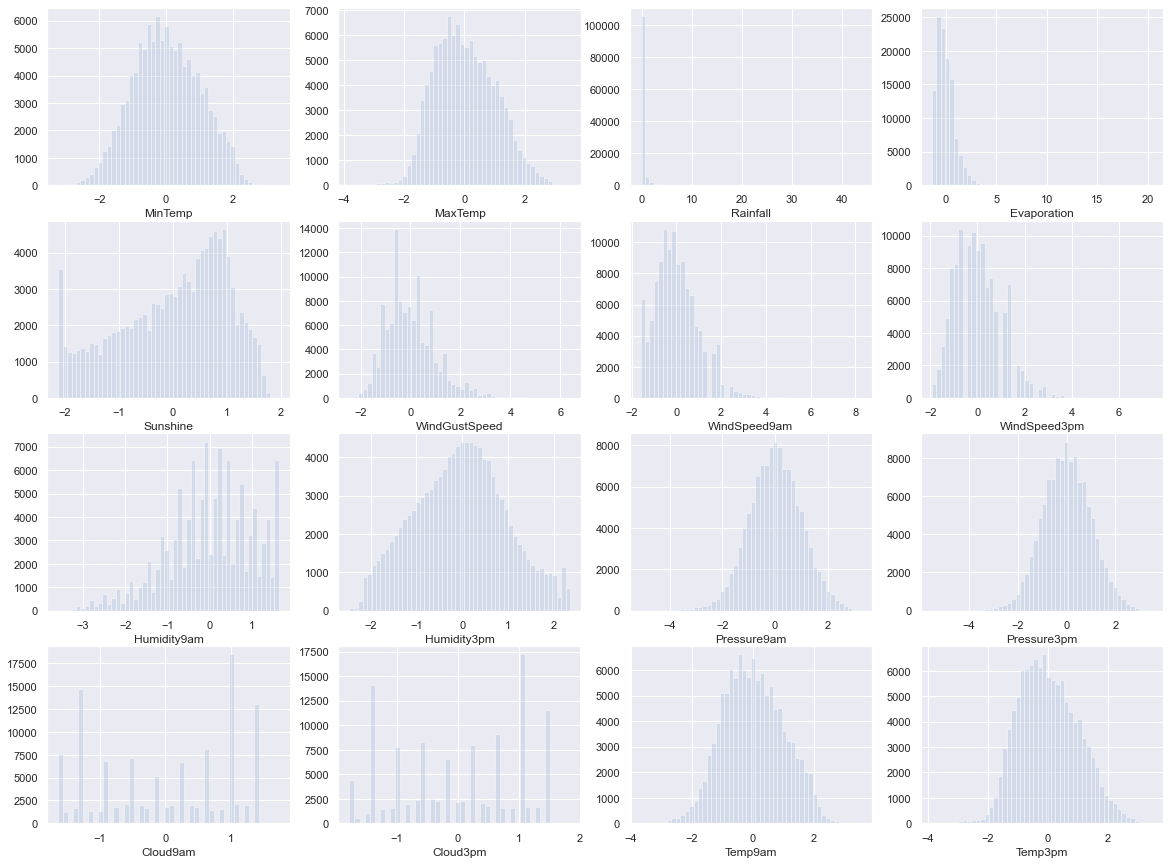

In [43]:
fig, axes = plt.subplots(4, 4, figsize=(20,15))

for i,col in enumerate(data_numerical):
    sns.set()
    sns.distplot(df[col], kde=False, ax=axes.flat[i], color="lightsteelblue")
    

Пройдемся по колонкам для поиска выбросов.

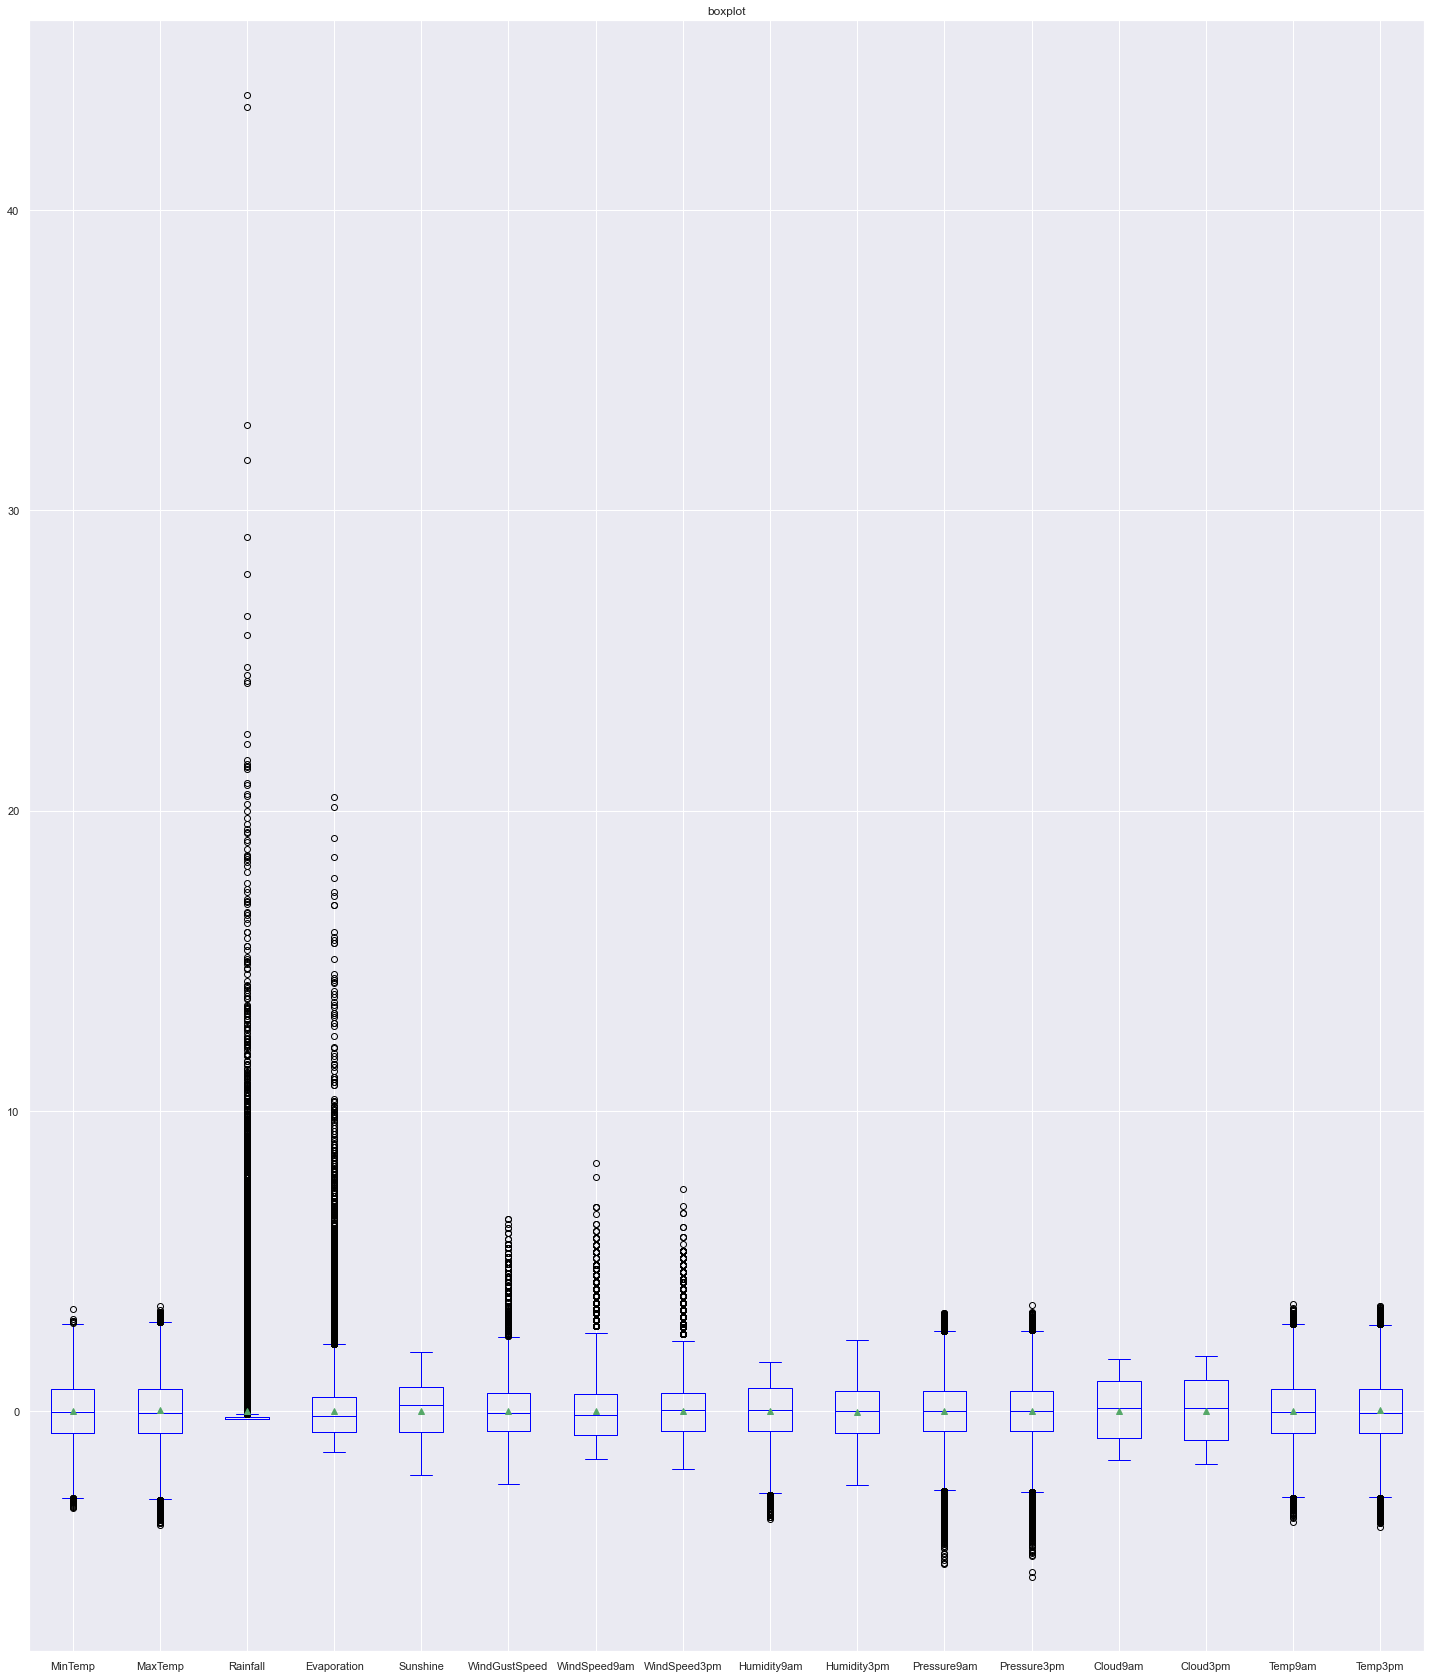

In [45]:
ax = df[num_cols].plot(kind='box', title='boxplot',figsize=(25, 30), showmeans=True, color="blue")
plt.show()

В некоторых колонках отчетливо видны выбросы. Найдем их границы.

Насчет 25 и 75 перцентилей: наверное, Вы правы, что выбор таких перцентилей очень ограничивает наши данные. Но дело в том, что я отталкиваюсь от формул нахождения межквартального расстояния и нахождения границ нашего боксплота. Честно говоря, я не совсем представляю, как будет удобнее и лучше подобрать границы, поэтому все-таки оставлю эту часть как есть, но выбросы удалять не буду :)

25-й перцентиль: -0.6882494695265656, 75-й перцентиль: 0.4772501991021833, IQR: 1.1654996686287489,  Границы выбросов: [-2.436498972469689, 2.2254997020453064].


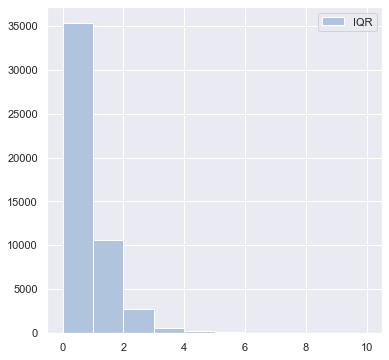

In [46]:
IQR = df.Evaporation.quantile(0.75) - df.Evaporation.quantile(0.25)
perc25 = df.Evaporation.quantile(0.25)
perc75 = df.Evaporation.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
df.Evaporation.loc[df.Sunshine.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR', color="lightsteelblue")
 
plt.legend();

In [ ]:
# Удалим выбросы
#df = df.loc[df.Evaporation.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

25-й перцентиль: -0.7092148846172688, 75-й перцентиль: 0.8080331871003842, IQR: 1.517248071717653,  Границы выбросов: [-2.9850869921937484, 3.083905294676864].


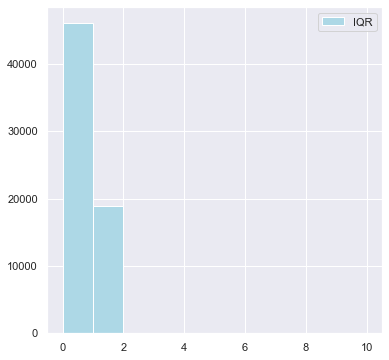

In [47]:
IQR = df.Sunshine.quantile(0.75) - df.Sunshine.quantile(0.25)
perc25 = df.Sunshine.quantile(0.25)
perc75 = df.Sunshine.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
df.Sunshine.loc[df.Sunshine.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR', color="lightblue")
 
plt.legend();

25-й перцентиль: -0.6616158742421505, 75-й перцентиль: 0.5994799656585051, IQR: 1.2610958399006558,  Границы выбросов: [-2.553259634093134, 2.491123725509489].


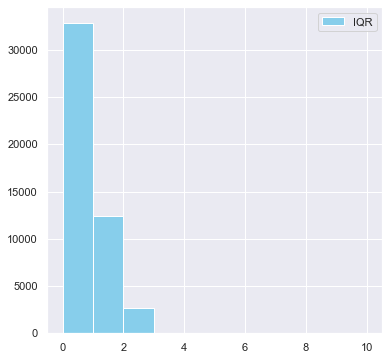

In [48]:
IQR = df.WindGustSpeed.quantile(0.75) - df.WindGustSpeed.quantile(0.25)
perc25 = df.WindGustSpeed.quantile(0.25)
perc75 = df.WindGustSpeed.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
df.WindGustSpeed.loc[df.WindGustSpeed.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR', color="skyblue")
 
plt.legend();

In [ ]:
# Выбросы есть. Удалим.
#df = df.loc[df.WindGustSpeed.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

25-й перцентиль: -0.8076602327859225, 75-й перцентиль: 0.5521652807771086, IQR: 1.359825513563031,  Границы выбросов: [-2.847398503130469, 2.5919035511216553].


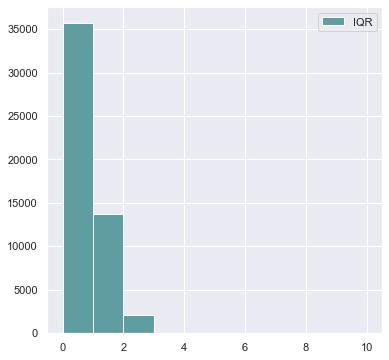

In [49]:
IQR = df.WindSpeed9am.quantile(0.75) - df.WindSpeed9am.quantile(0.25)
perc25 = df.WindSpeed9am.quantile(0.25)
perc75 = df.WindSpeed9am.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
df.WindSpeed9am.loc[df.WindSpeed9am.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR', color="cadetblue")
 
plt.legend();

In [ ]:
# Удалим выбросы
#df = df.loc[df.WindSpeed9am.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

25-й перцентиль: -0.6675889940413905, 75-й перцентиль: 0.6019112804444153, IQR: 1.269500274485806,  Границы выбросов: [-2.5718394057700995, 2.5061616921731242].


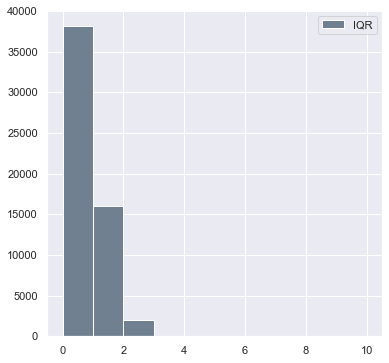

In [50]:
IQR = df.WindSpeed3pm.quantile(0.75) - df.WindSpeed3pm.quantile(0.25)
perc25 = df.WindSpeed3pm.quantile(0.25)
perc75 = df.WindSpeed3pm.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
df.WindSpeed3pm.loc[df.WindSpeed3pm.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR', color="slategray")
 
plt.legend();

In [ ]:
# Удалим выбросы
#df = df.loc[df.WindSpeed3pm.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

25-й перцентиль: -0.6570057882505963, 75-й перцентиль: 0.753375864338884, IQR: 1.4103816525894803,  Границы выбросов: [-2.7725782671348167, 2.8689483432231047].


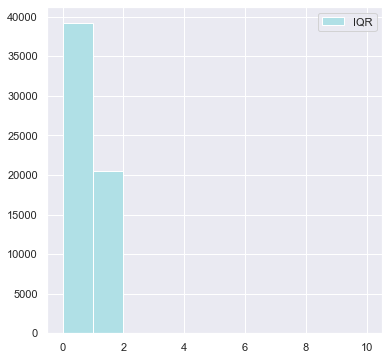

In [52]:
IQR = df.Humidity9am.quantile(0.75) - df.Humidity9am.quantile(0.25)
perc25 = df.Humidity9am.quantile(0.25)
perc75 = df.Humidity9am.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
df.Humidity9am.loc[df.Humidity9am.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR', color="powderblue")
 
plt.legend();

25-й перцентиль: -0.7252279186854673, 75-й перцентиль: 0.671642934992743, IQR: 1.3968708536782102,  Границы выбросов: [-2.8205341992027826, 2.766949215510058].


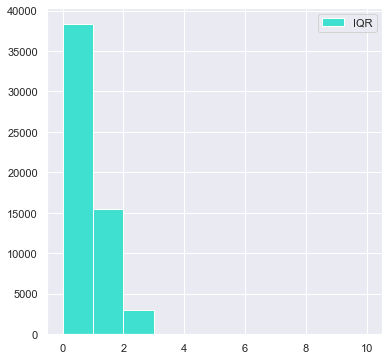

In [53]:
IQR = df.Humidity3pm.quantile(0.75) - df.Humidity3pm.quantile(0.25)
perc25 = df.Humidity3pm.quantile(0.25)
perc75 = df.Humidity3pm.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
df.Humidity3pm.loc[df.Humidity3pm.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR', color="turquoise")
 
plt.legend();

In [ ]:
#df = df.loc[df.Humidity3pm.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

25-й перцентиль: -0.8878840082966587, 75-й перцентиль: 0.9846387197931784, IQR: 1.872522728089837,  Границы выбросов: [-3.696668100431414, 3.793422811927934].


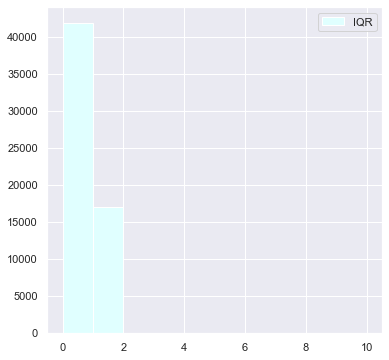

In [54]:
IQR = df.Cloud9am.quantile(0.75) - df.Cloud9am.quantile(0.25)
perc25 = df.Cloud9am.quantile(0.25)
perc75 = df.Cloud9am.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
df.Cloud9am.loc[df.Cloud9am.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR', color="lightcyan")
 
plt.legend();

25-й перцентиль: -0.9691851506186939, 75-й перцентиль: 1.0348912028314823, IQR: 2.004076353450176,  Границы выбросов: [-3.9752996807939582, 4.041005733006747].


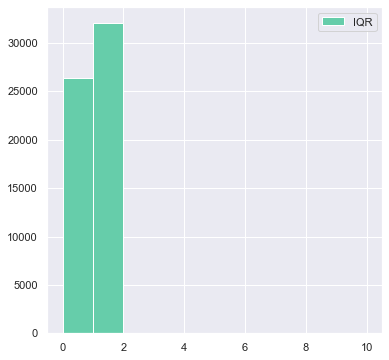

In [55]:
IQR = df.Cloud3pm.quantile(0.75) - df.Cloud3pm.quantile(0.25)
perc25 = df.Cloud3pm.quantile(0.25)
perc75 = df.Cloud3pm.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
df.Cloud3pm.loc[df.Cloud3pm.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR', color="mediumaquamarine")
 
plt.legend();

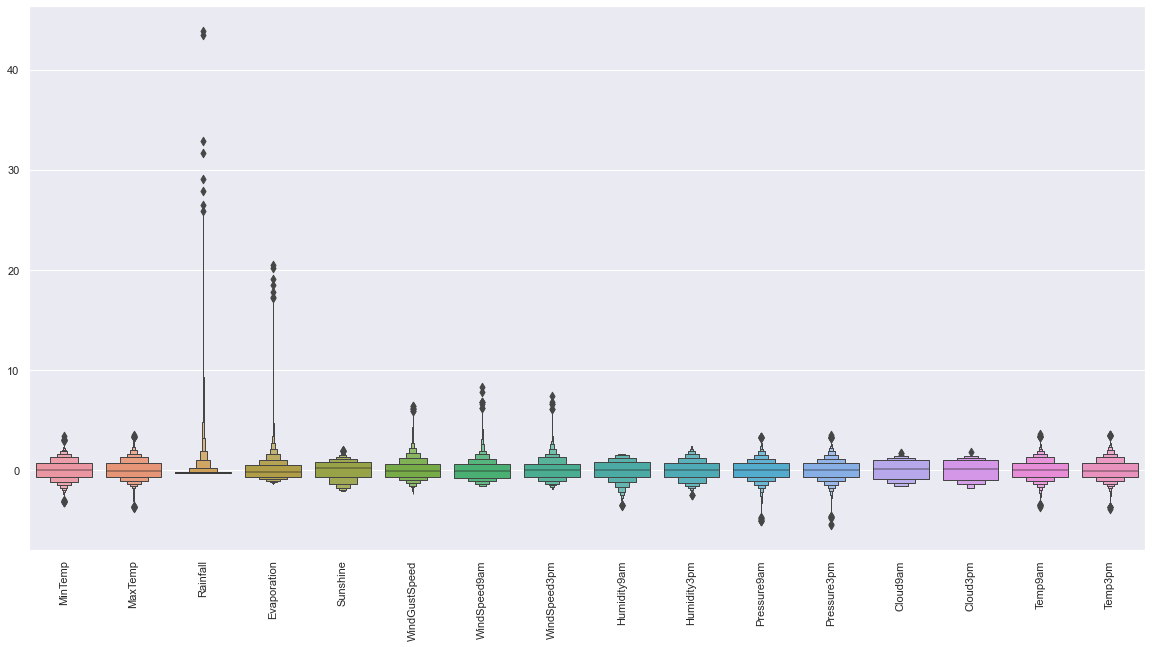

In [56]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = df[num_cols])
plt.xticks(rotation=90)
plt.show()

## Categorical

In [57]:
cat_cols = ["Location","WindGustDir","WindDir9am","WindDir3pm"]

In [58]:
df[cat_cols].isna().value_counts()

Location  WindGustDir  WindDir9am  WindDir3pm
False     False        False       False         115374
dtype: int64

In [59]:
data = df.copy() 

In [60]:
data['RainTomorrow'] = data['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# Посмотрим на зависимость уровня влажности и ветра по городам

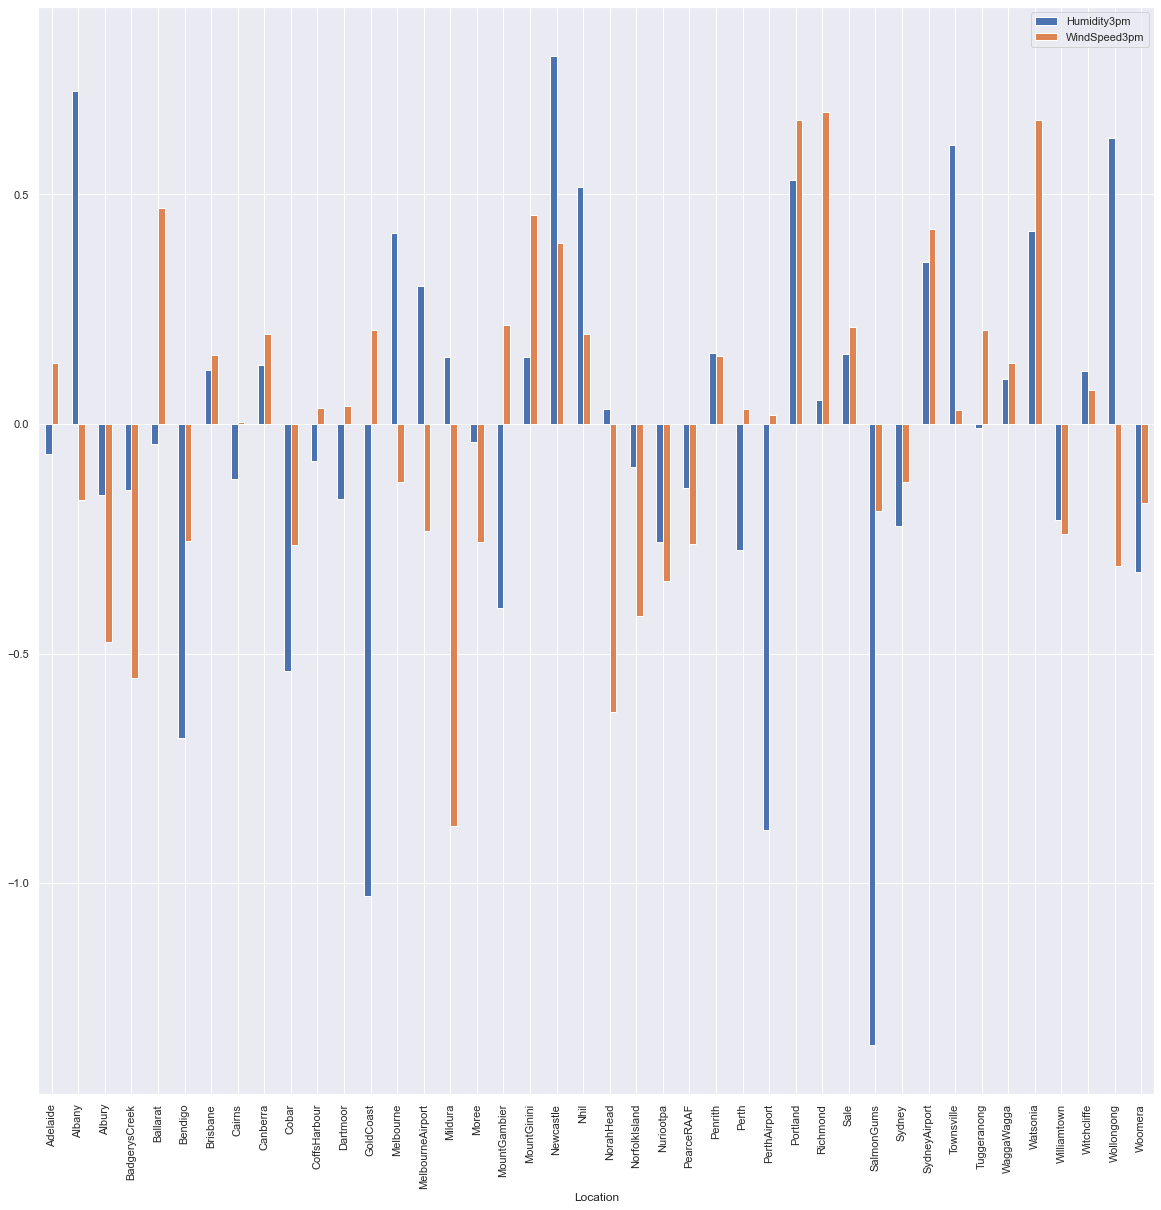

In [61]:
data.pivot_table(values = ['WindSpeed3pm', 'Humidity3pm'], 
               index = 'Location', 
               aggfunc = 'mean').plot(kind = 'bar', figsize=(20, 20))

In [ ]:
# Посмотрим на вероятность дождя в зависимости от горда и скорости ветра

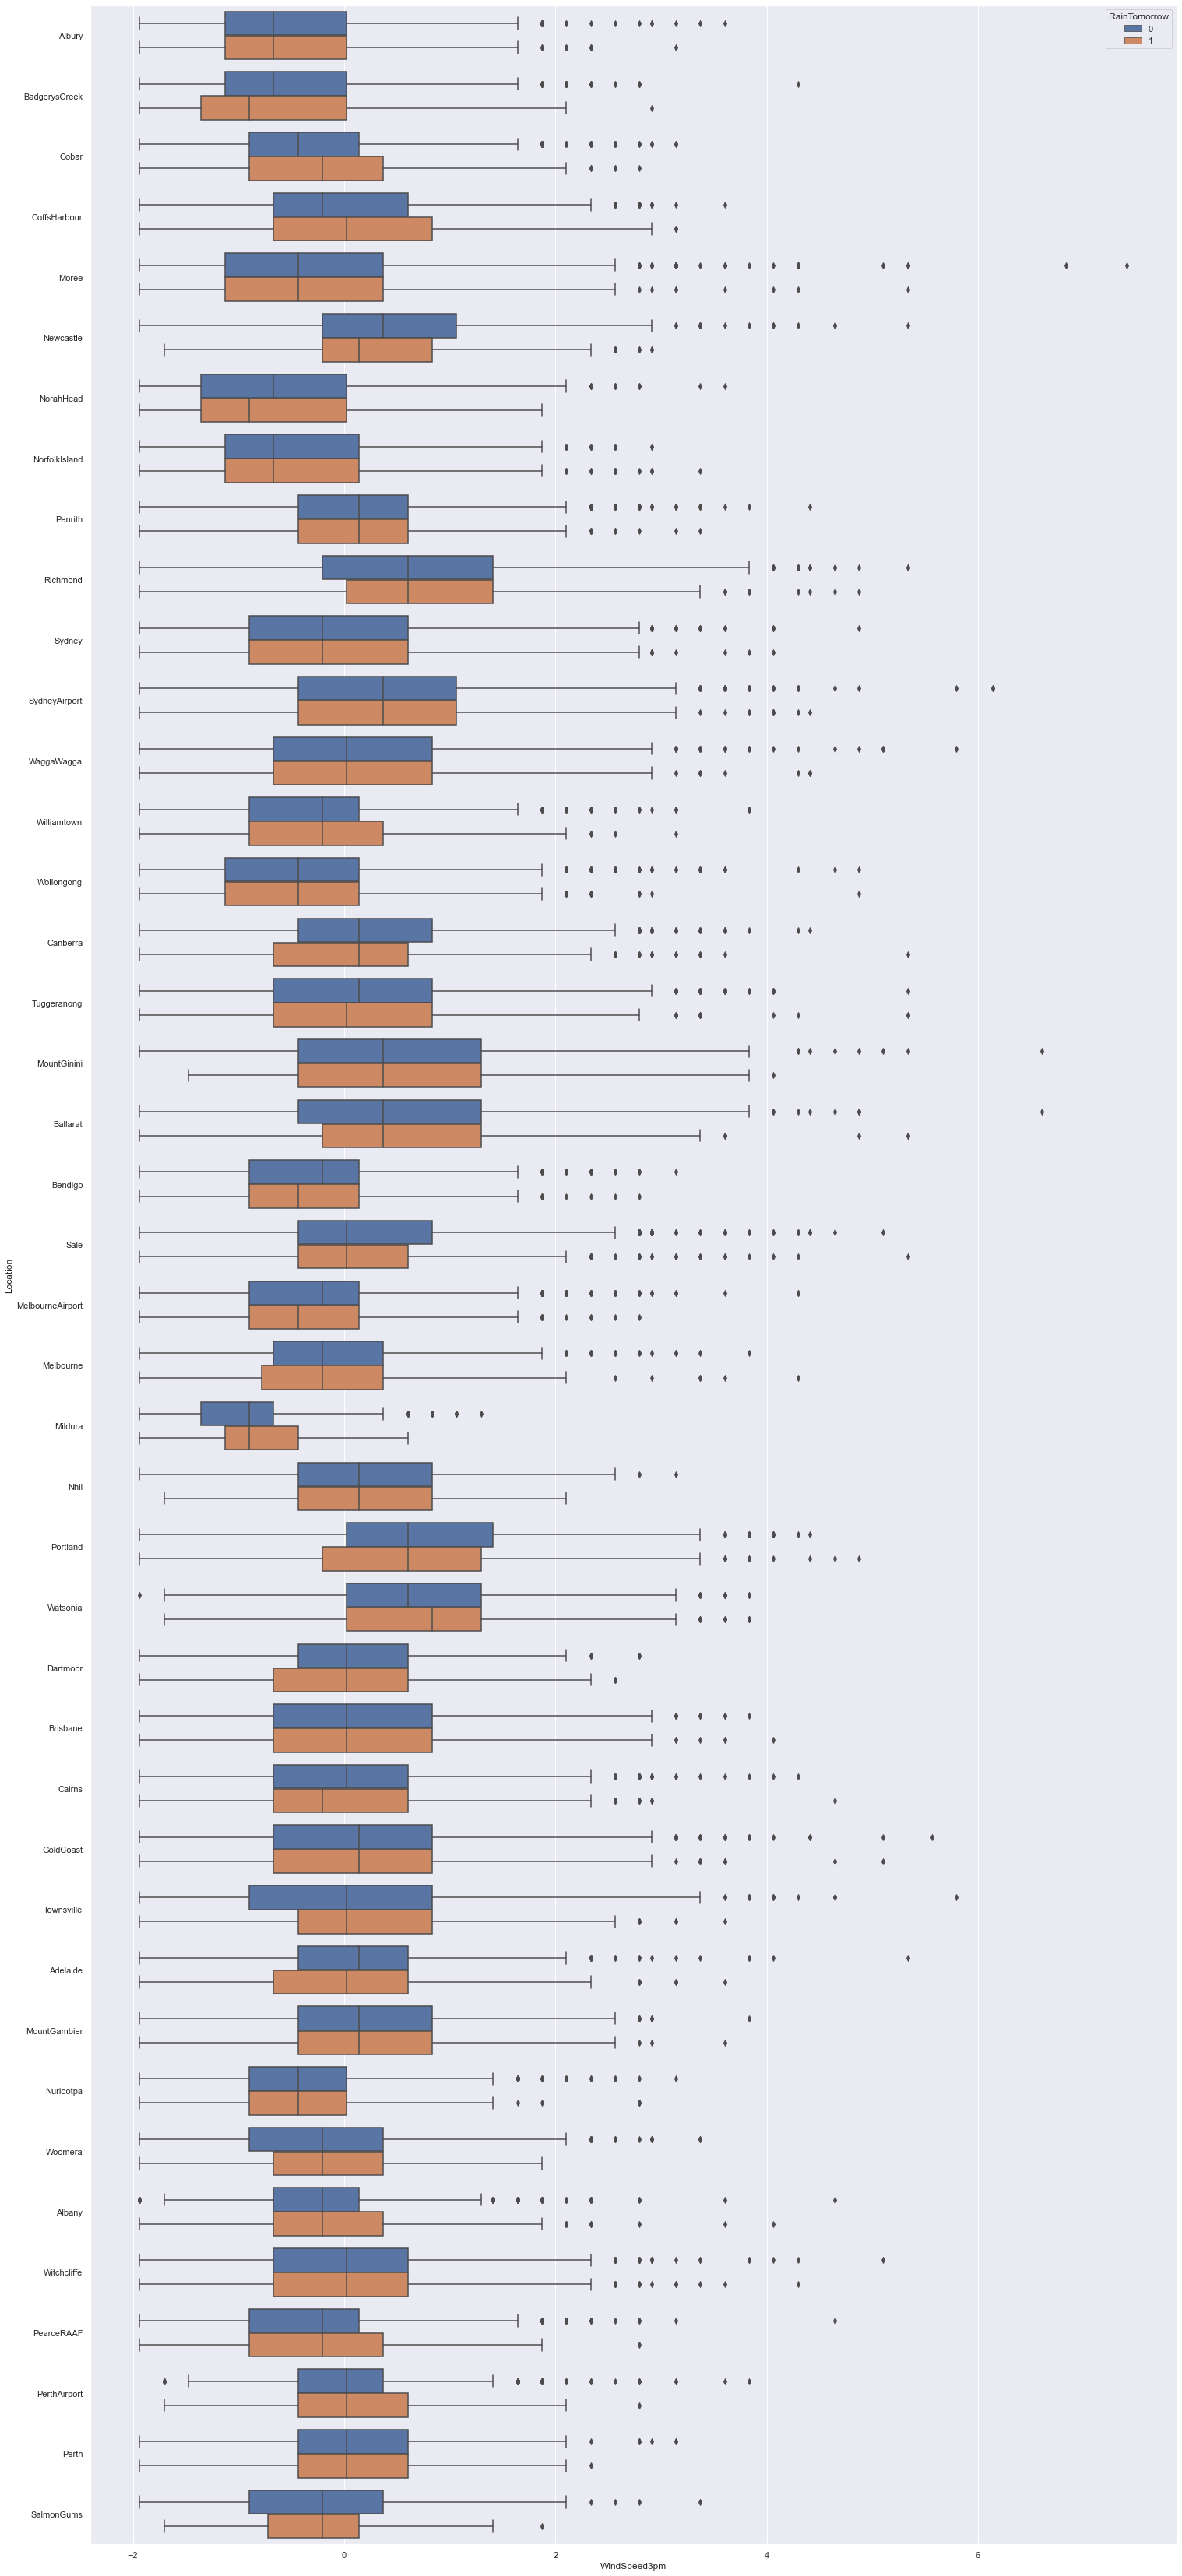

In [62]:
plt.figure(figsize=(25,60))
sns.boxplot(x="WindSpeed3pm", y="Location", hue="RainTomorrow", data=data)

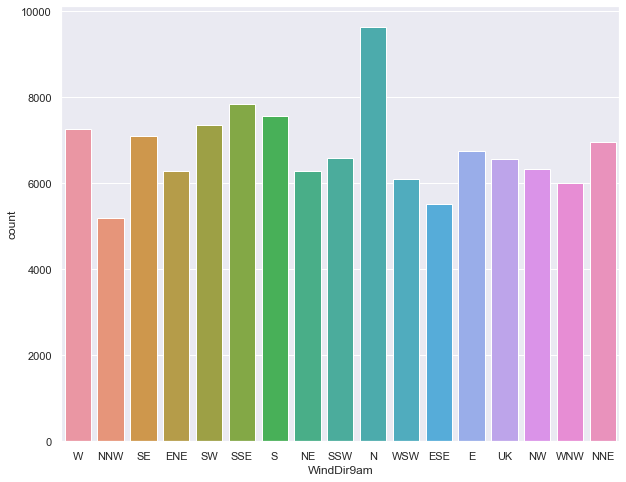

In [63]:
plt.figure(figsize=(10,8))
sns.countplot(x="WindDir9am", data=data)

### Кодируем категориальные признаки

In [64]:
# Кодируем наши признаки с помощью LabelEncoder
label_encoder = LabelEncoder()

In [65]:
mapped_data = {}
label_encoder = LabelEncoder()
for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col].astype(str))
    mapped_data[col] = dict(enumerate(label_encoder.classes_))

In [66]:
pprint.pprint(mapped_data)

{'Location': {0: 'Adelaide',
              1: 'Albany',
              2: 'Albury',
              3: 'BadgerysCreek',
              4: 'Ballarat',
              5: 'Bendigo',
              6: 'Brisbane',
              7: 'Cairns',
              8: 'Canberra',
              9: 'Cobar',
              10: 'CoffsHarbour',
              11: 'Dartmoor',
              12: 'GoldCoast',
              13: 'Melbourne',
              14: 'MelbourneAirport',
              15: 'Mildura',
              16: 'Moree',
              17: 'MountGambier',
              18: 'MountGinini',
              19: 'Newcastle',
              20: 'Nhil',
              21: 'NorahHead',
              22: 'NorfolkIsland',
              23: 'Nuriootpa',
              24: 'PearceRAAF',
              25: 'Penrith',
              26: 'Perth',
              27: 'PerthAirport',
              28: 'Portland',
              29: 'Richmond',
              30: 'Sale',
              31: 'SalmonGums',
              32: 'Sydney',
      

In [67]:
data

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location,WindGustDir,WindDir9am,WindDir3pm,RainTomorrow
0,0.187538,-0.057304,-0.203092,1.165955,0.648816,0.302752,0.665484,0.601911,0.126540,-1.399579,...,-1.187552,1.359143,-0.167555,-0.014172,0.000501,2,14,14,14,0
1,-0.749372,0.252579,-0.274444,0.795114,0.967251,0.302752,-1.147617,0.371093,-1.283842,-1.255075,...,-1.086183,-1.137554,-1.102790,0.031889,0.359475,2,15,6,15,0
2,0.109462,0.337092,-0.274444,0.512568,1.014079,0.451116,0.552165,0.832730,-1.597260,-1.014236,...,-0.955851,-1.137554,-0.969185,0.615325,0.201526,2,16,14,15,0
3,-0.468299,0.661060,-0.274444,0.565546,0.854862,-1.180891,-0.354385,-1.129225,-1.231606,-1.688587,...,-0.362118,-0.887884,-0.835580,0.170071,0.675373,2,4,9,0,0
4,0.827759,1.266739,-0.155524,-0.211454,0.330381,0.080205,-0.807660,0.140275,0.701140,-0.869732,...,-1.346846,0.984639,1.435706,0.124010,1.134860,2,14,1,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124767,-1.358363,-0.212245,-0.274444,-0.017204,1.145199,-0.661616,0.098890,-0.667589,-0.500297,-1.158740,...,0.854311,-1.636893,-1.770816,-1.165692,-0.128730,31,7,7,12,0
124768,-1.467669,0.013124,-0.274444,-0.211454,0.536427,-0.661616,-0.127747,-0.898407,-0.918188,-1.303243,...,0.723979,-0.763049,-0.969185,-1.058217,0.086655,31,14,16,7,0
124769,-1.342748,0.280750,-0.274444,-0.405704,0.751839,-1.329255,-0.127747,-1.129225,-0.657006,-1.447747,...,0.550203,-1.262389,-0.701975,-0.935388,0.388193,31,15,14,14,0
124770,-1.061675,0.506119,-0.274444,-0.052522,0.920422,-0.216523,-0.581023,-1.129225,-0.813715,-1.303243,...,0.217134,-0.887884,-0.835580,-0.689731,0.617937,31,11,14,11,0


In [ ]:
# Еще раз посмотрим на распределение целевой переменной

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


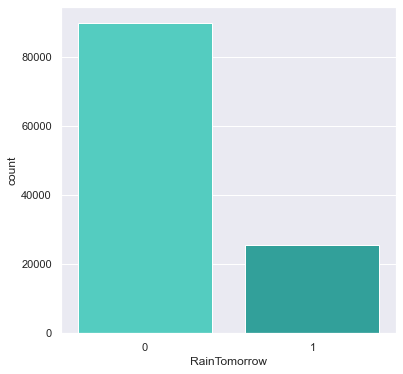

In [68]:
sns.countplot(data['RainTomorrow'], palette=['turquoise',"lightseagreen"])

Видим, что выборка несбалансированная. 

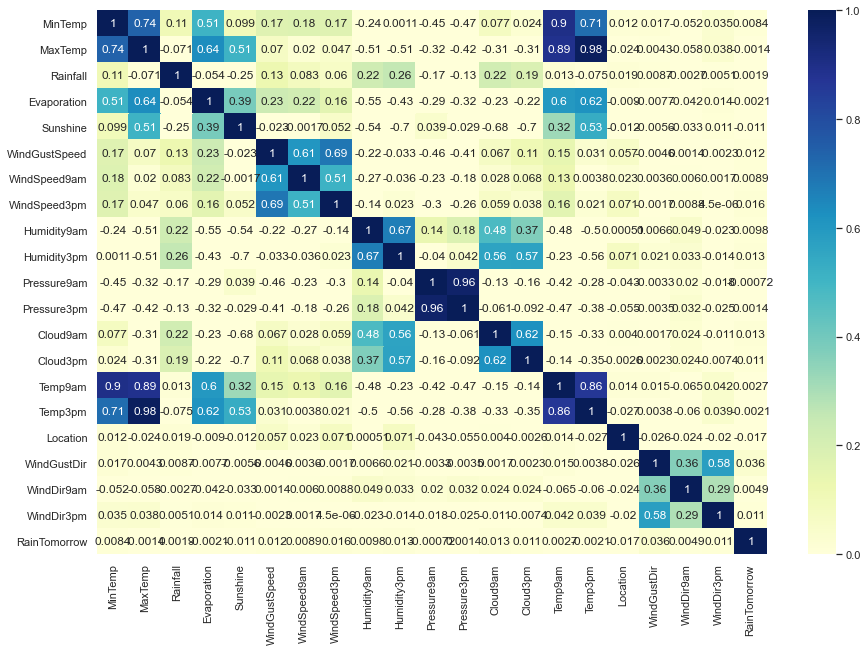

In [69]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(), vmin=0, vmax=1, annot = True, cmap="YlGnBu")

1) Сильная корреляция наблюдается между значением температуры (MinTemp, MaxTemp) и испарением (Evaporation)

2) Очевидно, что довольно сильная положительная корреляция будет между показателями в разное время суток(например, Temp9am и Temp3pm)

3) Исходя из отрицательной корреляции между Sunshine и Humidity ясно, что чем больше солнечного света, тем меньше уровень влажности. Напротив, видим положительную корреляцию между облачностью (Cloud) и уровнем влажности.


##### Найдем самые важные числовые признаки

In [70]:
data[num_cols].dropna()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,0.187538,-0.057304,-0.203092,1.165955,0.648816,0.302752,0.665484,0.601911,0.126540,-1.399579,-1.430972,-1.187552,1.359143,-0.167555,-0.014172,0.000501
1,-0.749372,0.252579,-0.274444,0.795114,0.967251,0.302752,-1.147617,0.371093,-1.283842,-1.255075,-1.016283,-1.086183,-1.137554,-1.102790,0.031889,0.359475
2,0.109462,0.337092,-0.274444,0.512568,1.014079,0.451116,0.552165,0.832730,-1.597260,-1.014236,-1.445271,-0.955851,-1.137554,-0.969185,0.615325,0.201526
3,-0.468299,0.661060,-0.274444,0.565546,0.854862,-1.180891,-0.354385,-1.129225,-1.231606,-1.688587,-0.015309,-0.362118,-0.887884,-0.835580,0.170071,0.675373
4,0.827759,1.266739,-0.155524,-0.211454,0.330381,0.080205,-0.807660,0.140275,0.701140,-0.869732,-0.987683,-1.346846,0.984639,1.435706,0.124010,1.134860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124767,-1.358363,-0.212245,-0.274444,-0.017204,1.145199,-0.661616,0.098890,-0.667589,-0.500297,-1.158740,0.999965,0.854311,-1.636893,-1.770816,-1.165692,-0.128730
124768,-1.467669,0.013124,-0.274444,-0.211454,0.536427,-0.661616,-0.127747,-0.898407,-0.918188,-1.303243,0.985665,0.723979,-0.763049,-0.969185,-1.058217,0.086655
124769,-1.342748,0.280750,-0.274444,-0.405704,0.751839,-1.329255,-0.127747,-1.129225,-0.657006,-1.447747,0.828369,0.550203,-1.262389,-0.701975,-0.935388,0.388193
124770,-1.061675,0.506119,-0.274444,-0.052522,0.920422,-0.216523,-0.581023,-1.129225,-0.813715,-1.303243,0.470878,0.217134,-0.887884,-0.835580,-0.689731,0.617937


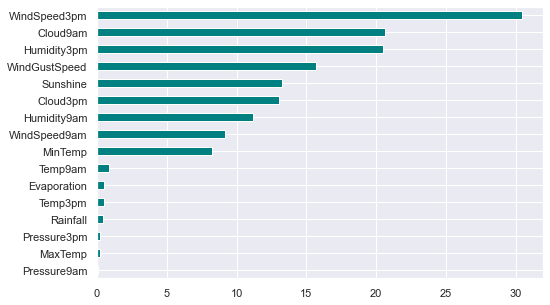

In [71]:
imp_num = pd.Series(f_classif(data[num_cols], data['RainTomorrow'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', figsize=(8,5), color="teal")

##### самые важные категориальные признаки

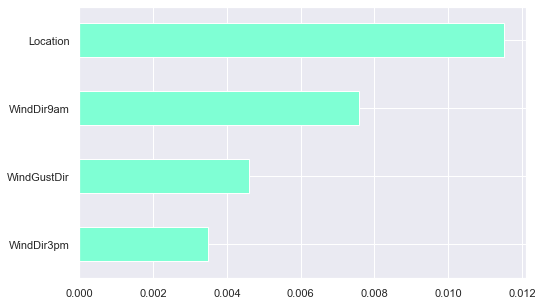

In [72]:
imp_cat = pd.Series(mutual_info_classif(data[cat_cols], data['RainTomorrow'],
                                     discrete_features = True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh',figsize=(8,5), color="aquamarine")

In [73]:
data.to_csv("generated.csv")

In [ ]:
data = pd.read_csv("generated.csv")

### Разделим наш датасет на тренировочную и тестовую выборки

In [74]:
X = data.drop(['RainTomorrow'], axis=1).values
y = data['RainTomorrow'].values # целевая переменная

In [ ]:
# df_train, df_test = train_test_split(df, shuffle=True, random_state=42, test_size=0.25)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.25)

In [76]:
# Задание 3: Построить свой DataLoader

class DataLoader:
    
    def __init__(self, X_data, y_data, batch_size=64, shuffle=True):
        self.X_data = X_data
        self.y_data = y_data
        self.batches = []
        self.batch_size = batch_size
        self.batches_per_epoch = len(self.X_data) // self.batch_size
        
    
    def __getitem__(self, index):
        # returns tuple(X_data[i], y_data[i])
        return (self.X_data[index], self.y_data[index])
    
    def __len__(self):
        # количество батчей
        return self.batches_per_epoch
        
        
    def __iter__(self):
        self.batches = []
        batch_idx = [i for i in np.random.permutation(self.X_data.shape[0])]
        for i in range(self.batches_per_epoch):
            one_batch_x = []
            one_batch_y = []
            for j in range(self.batch_size):
                rand_idx = random.choice(batch_idx)
                one_batch_x.append(self.X_data[rand_idx])
                one_batch_y.append(self.y_data[rand_idx])
                tup = (one_batch_x, one_batch_y)
        
            self.batches.append(tup)
        return iter(self.batches)
        
        
    def __next__(self):
        # returns tuple(X_data_batch, y_data_batch)
        try:
            yield self.batches
        except StopIteration:
            pass

        
        
    

In [77]:
train_loader, test_loader = DataLoader(X_train, y_train), DataLoader(X_test, y_test)

In [78]:
print(next(iter(train_loader)))

([array([-1.06167498e+00, -1.67714435e+00, -2.26876225e-01, -1.16504479e+00,
       -4.28243019e-01, -3.64887441e-01, -3.54385062e-01, -6.67588994e-01,
        1.01455765e+00,  1.10515458e+00,  1.32904051e-02, -4.20043473e-01,
       -8.87884008e-01,  1.03489120e+00, -1.45741072e+00, -1.59334672e+00,
        1.00000000e+00,  1.30000000e+01,  8.00000000e+00,  1.50000000e+01]), array([-0.60883532, -1.08555048,  0.12988408, -0.95313576, -0.48443739,
        2.28094109, -0.35438506,  3.83336652,  0.64890315,  1.58683418,
       -2.01725648, -1.27443999, -0.88788401,  1.0348912 , -1.04286351,
       -0.91847443, 34.        , 12.        , 11.        ,  2.        ]), array([-0.06230471,  0.80191568, -0.27444427,  0.58320471,  1.36061119,
       -0.06815901,  0.3255277 , -0.66758899, -1.38831479, -1.25507548,
        0.38508068,  0.14472711, -1.6368931 , -1.77081569,  0.20077812,
        0.89075767, 26.        , 12.        ,  1.        , 11.        ]), array([ 0.78091396,  0.18215068, -0.06038

In [ ]:
# Задание 4: Построить двухслойный перцептрон

class ShallowPerceptron(nn.Module):
    
    def __init__(self):
        super(ShallowPerceptron, self).__init__()
        
        # First nn.Linear shape: (n_features, hidden_size)
        self.layer_1 = None
        
        # Second nn.Linear shape: (hidden_size, hidden_size)
        self.layer_2 = None
        
        # Last nn.Linear shape: (hidden_size, 1)
        self.layer_out = None
        
        # Read about ReLU: https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning
        self.relu = nn.ReLU()
        
        # Read about Dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
        self.dropout = nn.Dropout(p=0.1)

        
    def forward(self, inputs):
        # Каждый слой по сути является функцией, в которую передаются некоторые input
        # Очередность: layer_1 --> relu --> layer_2 --> relu --> dropout --> layer_out
        return x

In [ ]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001


model = ShallowPerceptron()
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [ ]:
# Задание 5: написать цикл обучения

# Переводим модель в режим "тренировки"
model.train()


# Одна эпоха - один полный проход по данным 
for epoch in range(EPOCHS):
    
    # На каждой эпохе необходимо отслеживать суммарный лосс и считать метрику качества
    # В качестве метрики можно использовать F1 score
    epoch_loss = 0
    epoch_f1 = 0
    for X_batch, y_batch in train_loader:
        
        # Зануляем градиенты с предыдущего шага
        optimizer.zero_grad()
        
        # Делаем forward
        y_pred = model(X_batch)
        
        # Считаем лосс с помощью нашего criterion
        loss = None
        
        # Считаем метрику
        f1 = None
        
        # Делаем backpropagation
        loss.backward()
        
        # Изменяем веса
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_f1 += f1
        
    
    # Тут нужно вывести: Номер текущей эпохи | Лосс, усредненный на количество батчей | усредненный F1

In [ ]:
# Задание 6: Провести оценку на тестовых данных


model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        y_test_pred = model(X_batch)
        # Нужно сохранять результаты

# Здесь считаем метрику на полученных предсказаниях
# Радуемся!